# ModelingToolkit

# 2 Символьные преобразования

В основе MTK лежит система компьютерной алгебры [Symbolics.jl](https://symbolics.juliasymbolics.org/stable/), предназначенная для символьных вычислений, т.е. выполнения преобразований и работы с математическими выражениями в аналитической (символьной) форме.

Символьные преобразования, реализованные в MTK, позволяют изменить исходную формулировку модели и получить задачу, которая может быть решена более эффективно, чем исходная, либо, в случае нерешаемости исходной (в силу высокого порядка ОДУ или индекса дифференцируемости), сделать ее решаемой.

**alias_elimination()** - исключение псевдонимов; простое преобразование, которое проверяет в системе уравнения вида $y=x$ или $y=-x$ и просто заменяет все $y$ на $x$. Оно используется в более сложных преобразованиях, которые могут создавать псевдонимы, которые в целях оптимизации следует удалить.

**dae_order_lowering()** - преобразование дифуров высокого порядка к дифурам первого порядка

**dae_index_lowering()** - преобразование ДАУ с высоким индексом к ДАУ с индексом 1 (алгоритм Пантелидеса)

**tearing()** - преобразование системы уравнений к системе меньшей размерности путем разрыва алгебраических циклов. Заключается в выборе подмножества переменных $x_t$ таких, что если $x_t$ известно, то остальные переменные могут быть вычислены явным образом. NP-полная задача, используются эвристические алгоритмы, не гарантируется получение минимальной системы уравнений.

В большинстве случаев достаточно использовать функцию **structural_simplify()**, которая выполнит все необходимые преобразования автоматически


In [1]:
using ModelingToolkit, DifferentialEquations, Plots, Unitful

# 2.1 Пример работы tearing
Вернемся к примеру электрической цепи

![Image](http://ets.ifmo.ru/osipov/os1/3_2.files/image031.jpg)

\begin{equation*}
 \begin{cases}
   -i_1 + i_2 +i_L = 0 
   \\
   r_1 i_1 + r_2 i_2 =E
   \\
   u_L=L\frac{di_L}{dt}=r_2 i_2
 \end{cases}
\end{equation*}

где $r_1=r_2=0.2$, $L=0.01$, $E=10$, а начальные значения переменных $i_i(0)=i_2(0)=i_L(0)=0$ 

Обратим внимание, что уравнения в модели на МТК записаны не в форме `DAE`, как ранее, когда для алгебраических уравнений левая часть может включать только ноль, а для дифференциальных уравнений - производную, а в форме записи, какая удобна для пользователя. Преобразование автоматически приведет систему к требуемому для решателя виду.

In [2]:
@variables t [unit = u"s"]
@variables i₁(t) = 0 [unit=u"A"]
@variables i₂(t) = 0 [unit=u"A"]
@variables iₗ(t) = 0 [unit=u"A"]

@parameters E = 10.0 [unit=u"V"]
@parameters r₁ = 0.2 [unit=u"Ω"]
@parameters r₂ = 0.2 [unit=u"Ω"]
@parameters L = 0.01 [unit=u"H"]

D = Differential(t)
eqs = [
    i₁ ~ i₂ + iₗ
    E ~ r₁ * i₁ + r₂ * i₂
    L*D(iₗ) ~ r₂ * i₂
    ]

@named Circuit = ODESystem(eqs, t)

Model Circuit with 3 equations
States (3):
  i₁(t) [defaults to 0]
  i₂(t) [defaults to 0]
  iₗ(t) [defaults to 0]
Parameters (4):
  E [defaults to 10.0]
  r₁ [defaults to 0.2]
  r₂ [defaults to 0.2]
  L [defaults to 0.01]

Применение структурных преобразований уменьшает систему до 2-х уравнений:

In [3]:
sys = structural_simplify(Circuit)

Model Circuit with 2 equations
States (2):
  iₗ(t) [defaults to 0]
  i₂(t) [defaults to 0]
Parameters (4):
  E [defaults to 10.0]
  r₁ [defaults to 0.2]
  r₂ [defaults to 0.2]
  L [defaults to 0.01]
Incidence matrix:2×3 SparseArrays.SparseMatrixCSC{Num, Int64} with 4 stored entries:
 ⋅  ×  ×
 ×  ⋅  ×

Можно убедиться, что выполнено одно преобразование - tearing:

In [4]:
tearing(Circuit)

Model Circuit with 2 equations
States (2):
  iₗ(t) [defaults to 0]
  i₂(t) [defaults to 0]
Parameters (4):
  E [defaults to 10.0]
  r₁ [defaults to 0.2]
  r₂ [defaults to 0.2]
  L [defaults to 0.01]
Incidence matrix:2×3 SparseArrays.SparseMatrixCSC{Num, Int64} with 4 stored entries:
 ⋅  ×  ×
 ×  ⋅  ×

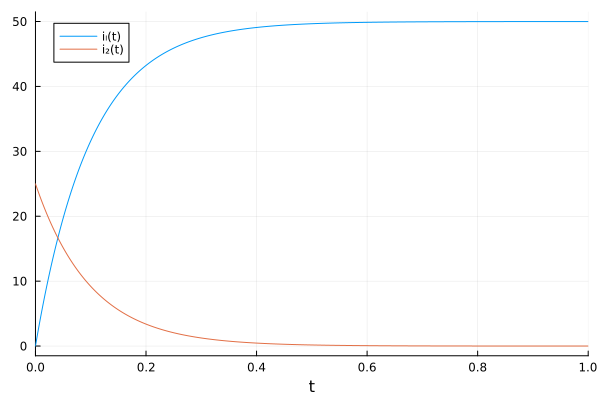

In [5]:
prob = ODEProblem(sys, [], [0.0, 1.0])
sol = solve(prob)
plot(sol)

In [6]:
states(sys)

2-element Vector{Any}:
 iₗ(t)
 i₂(t)

In [7]:
equations(sys)

2-element Vector{Equation}:
 Differential(t)(iₗ(t)) ~ (r₂*i₂(t)) / L
 0 ~ r₁*i₁(t) + r₂*i₂(t) - E

Одно уравнение было исключено в ходе преобразований, а переменная $i_1$, вычисляемая из него, перенесена в разряд "наблюдаемых", т.е. явно вычисляемых по оставшимся переменным редуцированной задачи:

In [8]:
observed(sys)

1-element Vector{Equation}:
 i₁(t) ~ i₂(t) + iₗ(t)

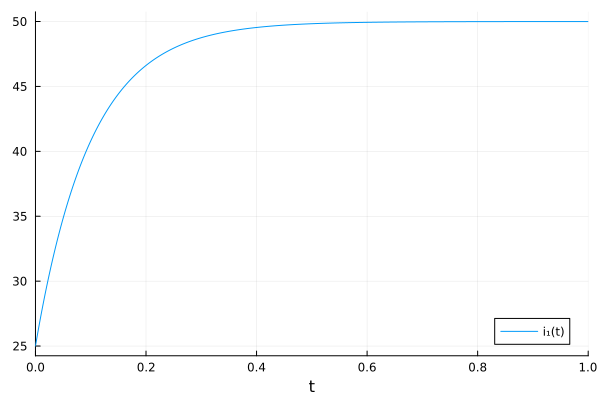

In [9]:
plot(sol, idxs=i₁)

# 2.2 Пример понижения порядка ОДУ

Колебания [математического маятника](https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%BC%D0%B0%D1%8F%D1%82%D0%BD%D0%B8%D0%BA) в полярной системе координат
![Image](https://upload.wikimedia.org/wikipedia/commons/1/1d/Simple-Pendulum-Labeled-Diagram.png)

описываются уравнением 2-го порядка
$$\frac {d^2\theta }{dt^2}+{\frac {g}{L}}\sin \theta =0$$
где $\theta$ - угол отклонения стержня от вертикали, $g$ - ускорение свободного падения, $L$ - длина стержня. 

Координаты $x$ и $y$ точки конца стержня:
$$ x=L\sin(\theta)$$
$$ y=-L\cos(\theta)$$

Поскольку нас интересуют в каждый момент времени координаты маятника $x$ и $y$, а не угол подвеса, добавим их в модель. Добавление уравнений для $x$ и $y$ не повлияет на размерность задачи, т.к. они явно вычисляются из переменной $\theta$ и, очевидно, будут исключены алгоритмом tearing.

In [10]:
@variables t [unit=u"s"]
@variables θ(t) = π/2 [unit=u"rad"] 
@variables x(t) [unit=u"m"] 
@variables y(t) [unit=u"m"]

@parameters L = 1 [unit=u"m"]
@constants g = 9.80665 [unit=u"m/s/s"]

D = Differential(t)
eqs = [
    D(D(θ)) + g / L * sin(θ) ~ 0
    x ~ L*sin(θ)
    y ~ -L*cos(θ)
    ]

@named PendulumPolar = ODESystem(eqs, t)

Model PendulumPolar with 3 equations
States (3):
  θ(t) [defaults to 1.5708]
  x(t)
  y(t)
Parameters (1):
  L [defaults to 1]

Применение преобразования, понижающего порядок, приводит к замене дифура 2-го порядка двумя дифурами 1-го порядка:

In [11]:
sys1 = dae_order_lowering(PendulumPolar)

Model PendulumPolar with 4 equations
States (4):
  θˍt(t)
  θ(t) [defaults to 1.5708]
  x(t)
  y(t)
Parameters (1):
  L [defaults to 1]

а последующий tearing уменьшает число уравнений

In [12]:
sys2 = tearing(dae_order_lowering(sys1))

Model PendulumPolar with 2 equations
States (2):
  θ(t) [defaults to 1.5708]
  θˍt(t)
Parameters (1):
  L [defaults to 1]
Incidence matrix:2×4 SparseArrays.SparseMatrixCSC{Num, Int64} with 4 stored entries:
 ⋅  ×  ×  ⋅
 ×  ⋅  ⋅  ×

Все это можно выполнить одной командой `structural_simplify()`:

In [13]:
sys = structural_simplify(PendulumPolar)

Model PendulumPolar with 2 equations
States (2):
  θ(t) [defaults to 1.5708]
  θˍt(t)
Parameters (1):
  L [defaults to 1]
Incidence matrix:2×5 SparseArrays.SparseMatrixCSC{Num, Int64} with 4 stored entries:
 ⋅  ×  ⋅  ×  ⋅
 ×  ⋅  ⋅  ⋅  ×

В итоге получили систему из двух дифуров первого порядка с двумя переменными состояния:

In [14]:
states(sys)

2-element Vector{Any}:
 θ(t)
 θˍt(t)

In [15]:
observed(sys)

3-element Vector{Equation}:
 y(t) ~ -L*cos(θ(t))
 x(t) ~ L*sin(θ(t))
 θˍtt(t) ~ (-g*sin(θ(t))) / L

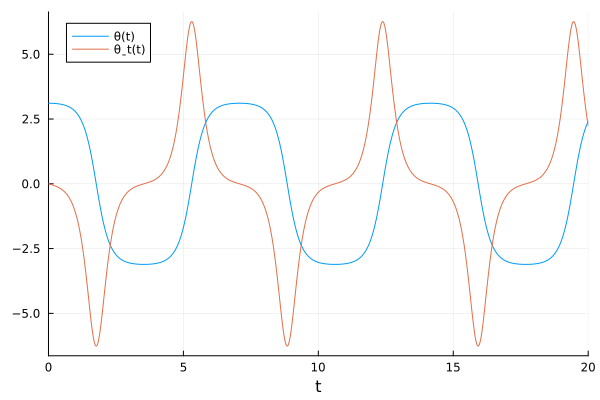

In [16]:
prob = ODEProblem(sys, [θ=>pi*0.99, D(θ)=>0.0], [0, 20])
sol = solve(prob, saveat=0.02, reltol=1e-8, abstol=1e-8);
plot(sol)

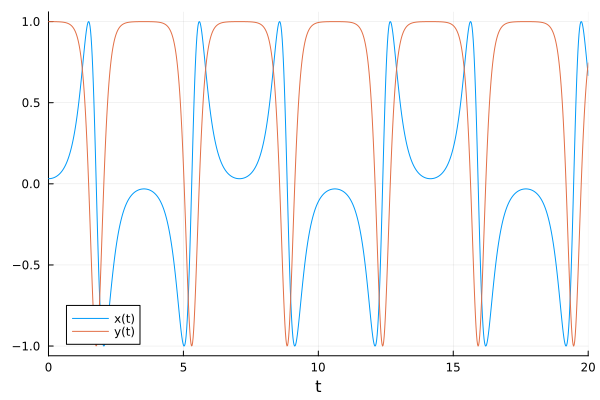

In [17]:
plot(sol, idxs=[x, y])

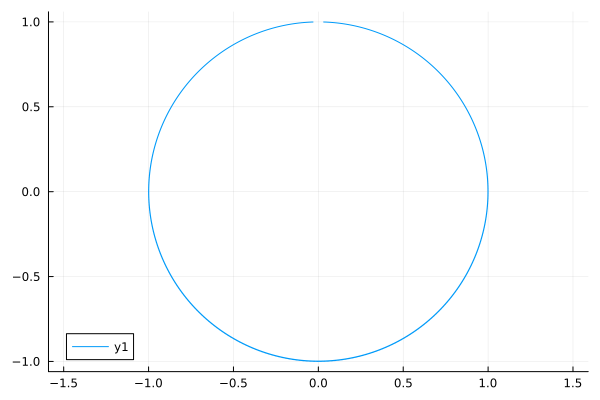

In [18]:
plot(sol[x], sol[y], aspect_ratio=1) 

[ Info: Saved animation to /home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif


Plots.AnimatedGif("/home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif")
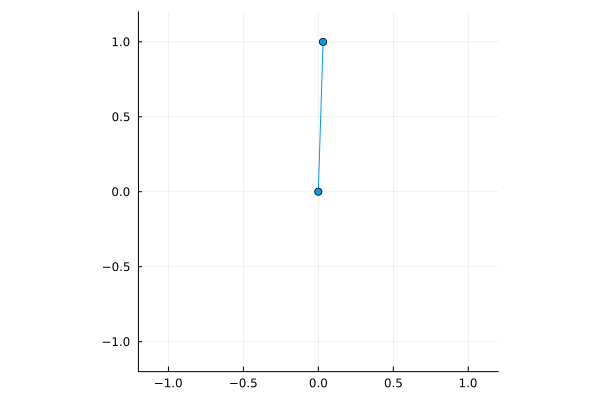

In [19]:
@gif for i in 1:1000
    plot([0; sol[x][i]], [0, sol[y][i]], 
        label="", xlims=(-1.2,1.2), ylims=(-1.2,1.2), marker=:circle, aspect_ratio=1)
end every 5

## 2.3 Пример понижения индекса ДАУ
Модель математического маятника в прямоугольной системе координат описывается системой дифференциально-алгебраических уравнений:

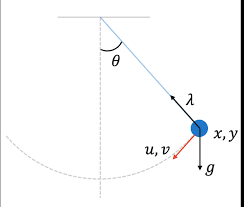


\begin{equation*}
 \begin{cases}
   \frac{dx}{dt} = u, 
   \\
   \frac{dy}{dt} = v,
   \\
   \frac{du}{dt} = - \lambda x 
   \\
   \frac{dv}{dt} = - \lambda y - g 
   \\
   0 = x^2 + y^2 -l^2
 \end{cases}
\end{equation*}

где $(x,y)$ - координаты положения маятника, $(u, v)$ - соответствующие скорости, $\lambda$ - коэффициент натяжения нити, $l$ - длина маятника, $g$ - ускорение свободного падения.

Система имеет индекс дифференцирования 3 и не может быть решена существующими решателями.

Пусть $l=1$, начальные координаты маятника $x(0)=1$, $y(0)=0$, начальная скорость $u(0)=v(0)=0$ и коэффициент натяжения $\lambda(0)=0$.

In [20]:
@variables t [unit = u"s"]
@variables x(t) = 1 [unit=u"m"]
@variables y(t) = 0 [unit=u"m"]
@variables u(t) = 0 [unit=u"m/s"]
@variables v(t) = 0 [unit=u"m/s"]
@variables λ(t) = 0 [unit=u"s^-2"]

@parameters l = 1.0 [unit=u"m"]

@parameters g = 9.80665 [unit=u"m/s^2"]

D = Differential(t)
eqs = [
    D(x) ~ u
    D(y) ~ v
    D(u) ~ -λ*x
    D(v) ~ -λ*y - g
    l^2 ~ x^2 + y^2 
]

@named PendulumCart = ODESystem(eqs, t)

Model PendulumCart with 5 equations
States (5):
  x(t) [defaults to 1]
  y(t) [defaults to 0]
  u(t) [defaults to 0]
  v(t) [defaults to 0]
  λ(t) [defaults to 0]
Parameters (2):
  g [defaults to 9.80665]
  l [defaults to 1.0]

Применим преобразование понижения индекса. Получившаяся система имеет индекс 1 и может быть решена DAE-решателями:

In [21]:
sys1 = dae_index_lowering(PendulumCart)

Model PendulumCart with 5 equations
States (5):
  x(t) [defaults to 1]
  y(t) [defaults to 0]
  u(t) [defaults to 0]
  v(t) [defaults to 0]
  λ(t) [defaults to 0]
Parameters (2):
  g [defaults to 9.80665]
  l [defaults to 1.0]

Заметим, что применение structural_simplify() не срабатывает

In [22]:
sys2 = structural_simplify(PendulumCart)

Model PendulumCart with 5 equations
States (5):
  y(t) [defaults to 0]
  v(t) [defaults to 0]
  u(t) [defaults to 0]
  x(t) [defaults to 1]
  λ(t) [defaults to 0]
Parameters (2):
  g [defaults to 9.80665]
  l [defaults to 1.0]
Incidence matrix:5×8 SparseArrays.SparseMatrixCSC{Num, Int64} with 16 stored entries:
 ⋅  ×  ⋅  ×  ⋅  ⋅  ⋅  ⋅
 ×  ⋅  ⋅  ⋅  ⋅  ×  ⋅  ×
 ×  ⋅  ⋅  ⋅  ×  ⋅  ⋅  ⋅
 ×  ×  ×  ⋅  ×  ⋅  ⋅  ⋅
 ×  ×  ×  ⋅  ×  ×  ⋅  ⋅

Поэтому применяем ее после понижения индекса:

In [23]:
sys3 = structural_simplify(dae_index_lowering(PendulumCart))

Model PendulumCart with 5 equations
States (5):
  x(t) [defaults to 1]
  u(t) [defaults to 0]
  y(t) [defaults to 0]
  v(t) [defaults to 0]
  λ(t) [defaults to 0]
Parameters (2):
  g [defaults to 9.80665]
  l [defaults to 1.0]
Incidence matrix:5×11 SparseArrays.SparseMatrixCSC{Num, Int64} with 15 stored entries:
 ⋅  ×  ⋅  ⋅  ×  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ×  ⋅  ⋅  ⋅  ⋅  ⋅  ×  ⋅  ⋅  ×  ⋅
 ⋅  ⋅  ⋅  ×  ⋅  ×  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ×  ⋅  ⋅  ⋅  ×  ⋅  ⋅  ⋅  ×
 ×  ×  ×  ×  ⋅  ⋅  ×  ⋅  ⋅  ⋅  ⋅

  4.517811 seconds (7.25 M allocations: 451.818 MiB, 2.01% gc time, 99.66% compilation time)


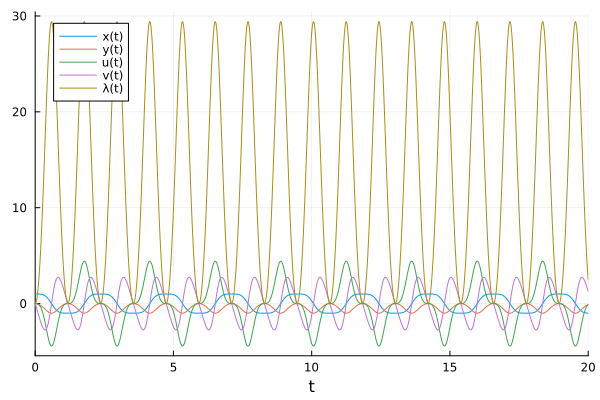

In [24]:
prob = ODEProblem(sys1, [x=>1, y=>0, u=>0.0, v=>0.0], [0.0, 20.0])
@time sol = solve(prob, Rodas4(), reltol=1e-8, abstol=1e-8, saveat=0.02)
plot(sol)

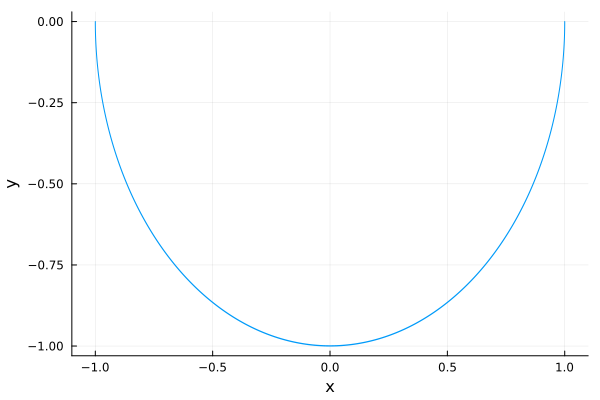

In [25]:
plot(sol, idxs=[(x,y)], label="", xlabel="x", ylabel="y")

[ Info: Saved animation to /home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif


Plots.AnimatedGif("/home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif")
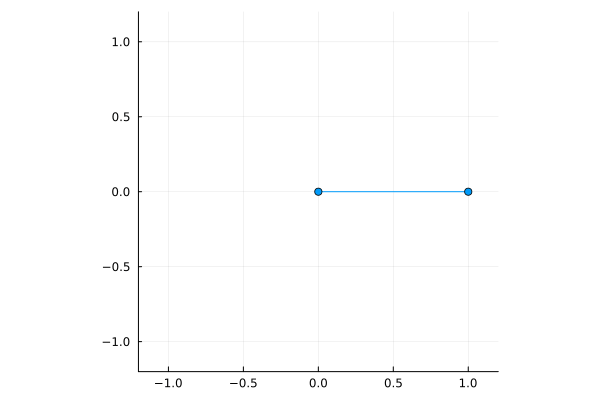

In [26]:
@gif for i in 1:1000
    plot([0, sol[x][i]], [0, sol[y][i]], 
        label="", xlims=(-1.2,1.2), ylims=(-1.2,1.2), marker=:circle, aspect_ratio=1)
end every 5

## 2.4 Дальнейшее упрощение c ODAEProblem

Некоторые системы можно упростить дальше и свести к ОДУ. Тогда можно использовать более эффективные ODE-решатели, например, `Tsit5`. Для этого вместо конструктора задачи `ODEProblem` применим `ODAEProblem`. Как видно из легенды графика, расчет выполняется для 4-х переменных вместо 5.

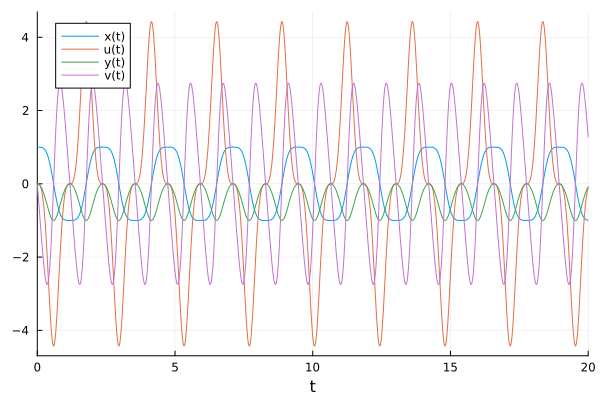

In [27]:
prob = ODAEProblem(sys3, [x=>1, y=>0, u=>0.0, v=>0.0], [0.0, 20.0])
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, saveat=0.02)
plot(sol)

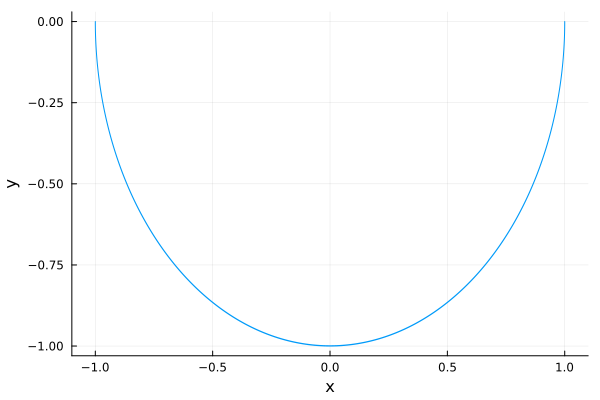

In [28]:
plot(sol, idxs=[(x, y)], label="", xlabel="x", ylabel="y")

### Решение в неявной форме DAE-решателем

Для решения DAE-решателями используется конструктор задачи `DAEProblem`. После первого аргумента передаются начальные значения производных. DAE-решатели могут быть эффективнее при решении больших разреженных задач 

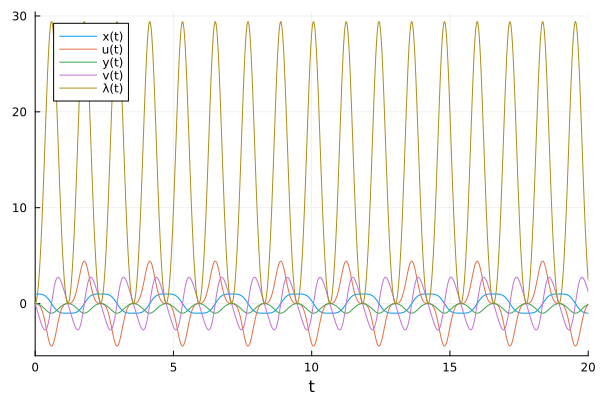

In [29]:
prob = DAEProblem(sys3, D.(states(sys3)).=>0.0, [x=>1, y=>0, u=>0.0, v=>0.0], [0.0, 20.0])
sol = solve(prob, DFBDF(), saveat=0.02, abstol=1e-8, reltol=1e-8)
plot(sol)

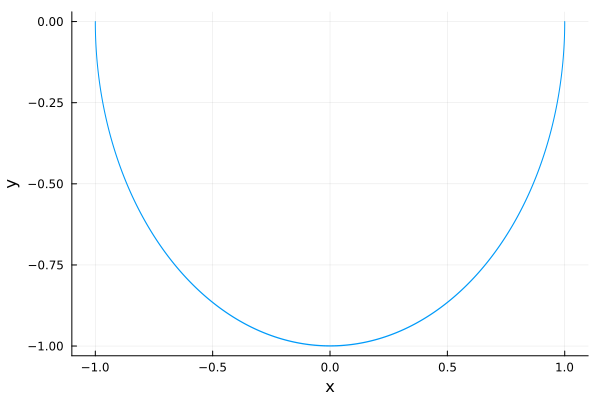

In [30]:
plot(sol, idxs=[(x, y)], label="", xlabel="x", ylabel="y")

## 2.5 Примеры более сложных систем

### 2.5.1 Двойной маятник в прямоугольной системе координат

Рассмотрим модель [двойного маятника](https://ru.wikipedia.org/wiki/%D0%94%D0%B2%D0%BE%D0%B9%D0%BD%D0%BE%D0%B9_%D0%BC%D0%B0%D1%8F%D1%82%D0%BD%D0%B8%D0%BA)
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Double-Pendulum.svg/800px-Double-Pendulum.svg.png" width=150 height=150 />

в декартовой системе координат

\begin{equation*}
 \begin{cases}
m_1 \frac{d^2x_1}{dt^2} = \frac{\lambda_1}{L_1} x_1 - \frac{\lambda_2}{L_2} (x_2 - x_1)
\\   
m_1 \frac{d^2y_1}{dt^2} = \frac{\lambda_1}{L_1} y_1 - \frac{\lambda_2}{L_2} (y_2 - y_1) - m_1
\\
m_2 \frac{d^2x_2}{dt^2} = \frac{\lambda_2}{L_2} (x_2 - x_1)
\\
m_2 \frac{d^2y_2}{dt^2} = \frac{\lambda_2}{L_2} (y_2 - y_1) - m_2 g
\\
x_1^2 + y_1^2 = L_1^2
\\
(x_2 - x_1)^2 + (y_2 - y_1)^2 = L_2^2
 \end{cases}
\end{equation*}



где $m_i$, $L_i$, $\lambda_i$ - массы, длины, силы натяжения верхнего ($i=1$) и нижнего ($i=2$) маятников.

Она описывается системой дифференциально алгебраических уравнений, которые имеют и порядок и индекс выше 1


In [31]:
@variables t [unit = u"s"]
@variables x₁(t) = 1 [unit=u"m"]
@variables y₁(t) = 0 [unit=u"m"]
@variables x₂(t) = 2 [unit=u"m"]
@variables y₂(t) = 0 [unit=u"m"]
@variables λ₁(t) = 0 [unit=u"N"]
@variables λ₂(t) = 0 [unit=u"N"]

@parameters L₁ = 1.0 [unit=u"m"]
@parameters L₂ = 1.0 [unit=u"m"]
@parameters m₁ = 1.0 [unit=u"kg"]
@parameters m₂ = 1.0 [unit=u"kg"]

@parameters g = 9.80665 [unit=u"m/s^2"]

D = Differential(t)
eqs = [
    m₁*D(D(x₁)) ~ λ₁/L₁*x₁ - λ₂/L₂*(x₂-x₁)
    m₁*D(D(y₁)) ~ λ₁/L₁*y₁ - λ₂/L₂*(y₂-y₁) - g*m₁
    m₂*D(D(x₂)) ~ λ₂/L₂*(x₂-x₁)
    m₂*D(D(y₂)) ~ λ₂/L₂*(y₂-y₁) - g*m₁
    L₁^2 ~ x₁^2 + y₁^2
    L₂^2 ~ (x₂-x₁)^2 + (y₂-y₁)^2
]

@named DoublePendulumCart = ODESystem(eqs, t)

Model DoublePendulumCart with 6 equations
States (6):
  x₁(t) [defaults to 1]
  x₂(t) [defaults to 2]
  λ₂(t) [defaults to 0]
  λ₁(t) [defaults to 0]
  y₁(t) [defaults to 0]
  y₂(t) [defaults to 0]
Parameters (5):
  m₁ [defaults to 1.0]
  L₂ [defaults to 1.0]
  L₁ [defaults to 1.0]
  g [defaults to 9.80665]
  m₂ [defaults to 1.0]

In [32]:
sys = structural_simplify(dae_index_lowering(DoublePendulumCart))

Model DoublePendulumCart with 10 equations
States (10):
  x₁(t) [defaults to 1]
  x₁ˍt(t)
  y₁(t) [defaults to 0]
  y₁ˍt(t)
  x₂(t) [defaults to 2]
  x₂ˍt(t)
⋮
Parameters (5):
  m₁ [defaults to 1.0]
  L₂ [defaults to 1.0]
  L₁ [defaults to 1.0]
  g [defaults to 9.80665]
  m₂ [defaults to 1.0]
Incidence matrix:10×22 SparseArrays.SparseMatrixCSC{Num, Int64} with 44 stored entries:
⠊⡠⠂⡀⠈⠠⠀⠀⣒⢂⠀
⠂⡀⠊⡠⠀⠀⠈⠠⡂⠀⢂
⠛⠛⠓⠓⠀⠀⠀⠀⠛⠀⠀

MTK успешно преобразует систему к решаемой: 

  4.131108 seconds (6.06 M allocations: 378.118 MiB, 2.36% gc time, 98.98% compilation time)


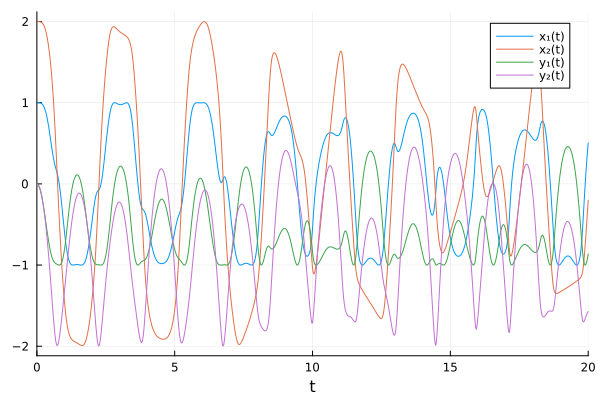

In [33]:
prob = ODEProblem(sys, [x₁=>1, y₁=>0.0, x₂=>2, y₂=>0.0, D(x₁)=>0.0, D(y₁)=>0.0, D(x₂)=>0.0, D(y₂)=>0.0], 
    [0.0, 20.0], [L₁=>1.0, L₂=>1.0])
@time sol = solve(prob, Rodas4(), reltol=1e-8, abstol=1e-8, saveat=0.02)
plot(sol, idxs=[x₁, x₂, y₁, y₂])

Двойной маятник демонстрирует хаотическую динамику

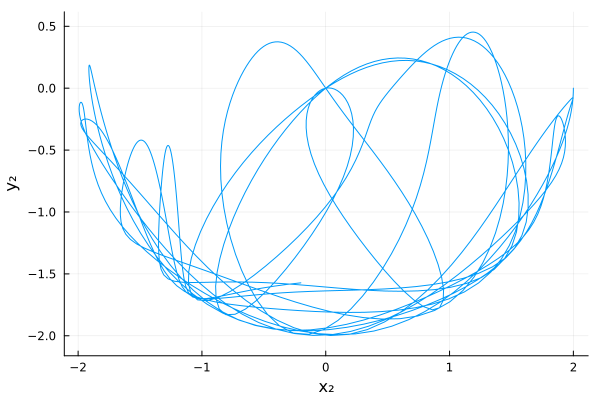

In [34]:
plot(sol[x₂], sol[y₂], aspect_ratio=1, xlabel="x₂", ylabel="y₂", label="")

[ Info: Saved animation to /home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif


Plots.AnimatedGif("/home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif")
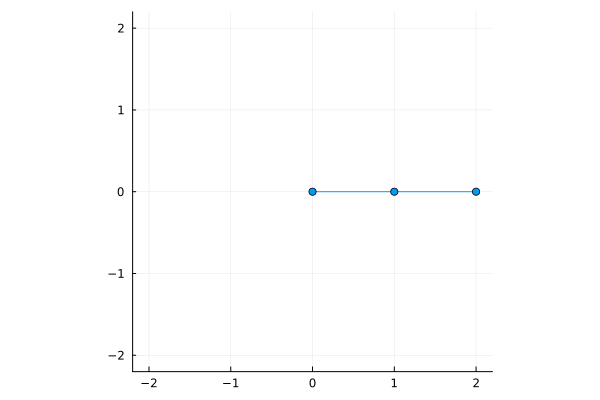

In [35]:
@gif for i in 1:1000
    plot([0, sol[x₁][i], sol[x₂][i]], [0, sol[y₁][i], sol[y₂][i]], 
        label="", xlims=(-2.2,2.2), ylims=(-2.2,2.2), marker=:circle, aspect_ratio=1)
end every 5

### 2.5.2 Двойной маятник в полярной системе координат
Как и для обычного маятника модель двойного маятника упрощается, если перейти к полярной системе координат:

\begin{equation*}
 \begin{cases}
(m_1+m_2) L_1 \frac{d^2\theta_1}{dt^2} + m_2 L_2 \frac{d^2\theta_2}{dt^2} \cos(\theta_2-\theta_1) = m_2 L_2 \left( \frac{d\theta_2}{dt} \right)^2 \sin(\theta_2-\theta_1) - (m_1+m_2)g\sin\theta_1 
\\
L_2 \frac{d^2\theta_2}{dt^2} + L_1 \frac{d^2\theta_1}{dt^2} \cos(\theta_2-\theta_1) = -L_1 \left( \frac{d\theta_1}{dt} \right)^2 sin(\theta_2-\theta_1) - g \sin\theta_2
  \end{cases}
\end{equation*}

где $m_i$, $\lambda_i$ и $\theta_i$ - массы, длины и углы верхнего ($i=1$) и нижнего ($i=2$) маятников.

Координаты концов верхнего и нижнего маятников:

\begin{equation*}
 \begin{cases}
 x_1 = L_1 \sin θ_1
 \\
 y_1 = -L_1\cos θ_1
 \\
 x_2 = x_1 + L_2\sin θ_2
 \\
 y_2 = y_1 - L_2 \cos θ_2
  \end{cases}
\end{equation*}    

In [36]:
# Самостоятельно

### 2.5.3 Маятник Капицы

Особенностью [маятника Капицы](https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%8F%D1%82%D0%BD%D0%B8%D0%BA_%D0%9A%D0%B0%D0%BF%D0%B8%D1%86%D1%8B) является то, что, вопреки интуиции, перевёрнутое (вертикальное) положение маятника может быть устойчивым в случае быстрых вибраций подвеса.


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a1/Kapitza_pendulum.svg/800px-Kapitza_pendulum.svg.png" width=150 height=150 />

Если основание маятника колеблется в соответствии с простыми гармоническими колебаниями 
$ y_0 = A\sin \omega t$, тогда уравнение движение маятника:

$$\frac {d^2\theta }{dt^2}-{\frac {g}{L}}\sin \theta = - \frac{A}{L}\omega^2 \sin(\omega t)\sin \theta$$
где $\theta$ - угол отклонения стержня от вертикали, $g$ - ускорение свободного падения, $L$ - длина стержня. 

Координаты $x$ и $y$ точки конца стержня:
$$ x=-L\sin(\theta)$$
$$ y=y_0+L\cos(\theta)$$


In [37]:
@variables t [unit = u"s"]
@variables θ(t) = 10/180*pi [unit = u"rad"]
@variables x(t) [unit = u"m"]
@variables y(t) [unit = u"m"]
@variables y₀(t) [unit = u"m"]

@parameters L = 1 [unit = u"m"]
@parameters A = 0.05 [unit = u"m"]
@parameters ω = 100 [unit = u"rad/s"]

@constants g = 9.80665 [unit = u"m/s^2"]

D = Differential(t)
eqs = [
    D(D(θ)) - g / L * sin(θ) ~ - A / L * ω^2 * sin(ω*t) * sin(θ)
    x ~ - L * sin(θ)
    y ~ y₀ + L * cos(θ)
    y₀ ~ A * sin(ω*t)
    ]

@named PendulumKapitza = ODESystem(eqs, t)

Model PendulumKapitza with 4 equations
States (4):
  θ(t) [defaults to 0.174533]
  x(t)
  y(t)
  y₀(t)
Parameters (3):
  L [defaults to 1]
  A [defaults to 0.05]
  ω [defaults to 100]

In [38]:
sys = structural_simplify(PendulumKapitza)

Model PendulumKapitza with 2 equations
States (2):
  θ(t) [defaults to 0.174533]
  θˍt(t)
Parameters (3):
  L [defaults to 1]
  A [defaults to 0.05]
  ω [defaults to 100]
Incidence matrix:2×5 SparseArrays.SparseMatrixCSC{Num, Int64} with 4 stored entries:
 ⋅  ×  ⋅  ×  ⋅
 ×  ⋅  ⋅  ⋅  ×

  4.337142 seconds (5.53 M allocations: 361.685 MiB, 3.84% gc time, 92.90% compilation time)


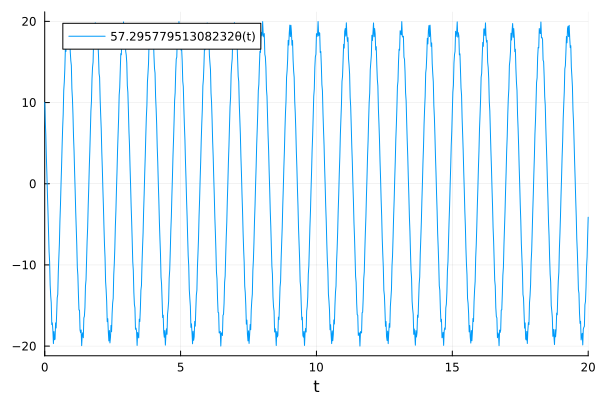

In [39]:
prob = ODEProblem(sys, D.(states(sys)) .=> 0.0, [0.0, 20.0], [A=>0.05, ω=>200, L=>1])
@time sol = solve(prob, Rodas4(), reltol=1e-8, abstol=1e-8, saveat=0.02)
plot(sol, idxs=θ*180/pi)

[ Info: Saved animation to /home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif


Plots.AnimatedGif("/home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif")
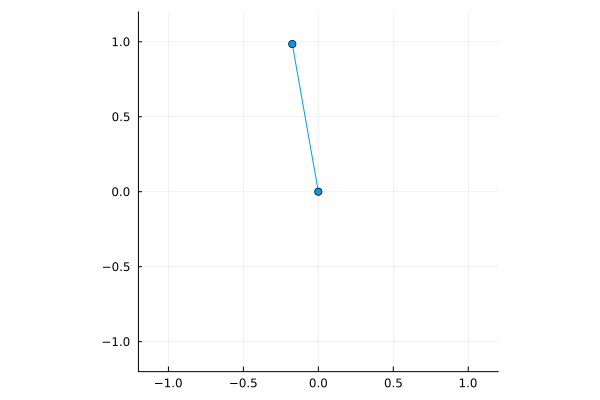

In [40]:
@gif for i in 1:1000
    plot([0, sol[x][i]], [sol[y₀][i], sol[y][i]], 
        label="", xlims=(-1.2, 1.2), ylims=(-1.2, 1.2), marker=:circle, aspect_ratio=1)
end every 1

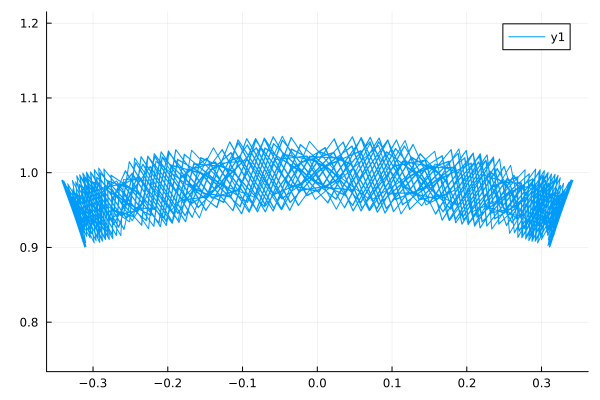

In [41]:
plot(sol[x],sol[y], aspect_ratio=1)